# Example Agent code generation

In [1]:
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.chat_models import ChatOllama
from langchain.output_parsers import CommaSeparatedListOutputParser

from typing_extensions import TypedDict

from langgraph.graph import StateGraph

from langchain_core.prompts import PromptTemplate

from IPython.display import Image, display

llm = ChatOllama(model = "llama3", base_url="http://ollama:11434")

In [7]:
class State(TypedDict):
    question: str
    tests: str
    code: str
    graded: str
    iter: int
    maxIters: int

## Test generator

In [8]:
prompt = """You are an expert test writer for python code. Create a reasonable set of tests in python for the following program description.

{question}.

Reply only with the python code module and no preamble"""

promptTemplate = PromptTemplate.from_template(prompt)

testGenerator = promptTemplate | llm

def writeTests(state: State):
    print("-----------generating tests-----------")
    tests = testGenerator.invoke({"question": state["question"]}).content
    print(f"{tests=}")
    return {"tests": tests} 

In [9]:
tests = writeTests({"question": "Create a program that takes a pandas DataFrame prints summary statisticas and plots all numeric data in a boxplot."})
print(tests["tests"])

-----------generating tests-----------
tests='```\nimport unittest\nfrom pandas import DataFrame\nfrom scipy.stats import normaltest\nfrom matplotlib.pyplot import show, figure\n\nclass TestPlotNumericData(unittest.TestCase):\n\n    def test_summary_statistics(self):\n        df = DataFrame({\'A\': [1, 2, 3], \'B\': [4, 5, 6]})\n        result = df.describe()\n        self.assertIsInstance(result, DataFrame)\n        self.assertEqual(result.shape[0], 2)\n\n    @unittest.skipIf(normaltest(df).statistic < 0.9, "Non-normal data")\n    def test_boxplot(self):\n        import numpy as np\n        from matplotlib.pyplot import boxplot\n\n        df = DataFrame({\'A\': [1, 2, 3], \'B\': [4, 5, 6]})\n        numeric_cols = [col for col in df.columns if df[col].dtype.kind == \'i\']\n        figure()\n        boxplot([df[col] for col in numeric_cols])\n        show()\n\n    def test_plotting_non_numeric_data(self):\n        import matplotlib.pyplot as plt\n\n        df = DataFrame({\'A\': [\'a\'

## Code generator

In [28]:
prompt = """You are an expert python coder. Create the necessary code in python to achieve the following program description.

{question}.

The program should pass the following tests

{tests}

Reply only with the python code module with the code, excluding the tests and no preamble."""

promptTemplate = PromptTemplate.from_template(prompt)

codeGenerator = promptTemplate | llm

def writeCode(state: State):
    print("-----------generating code-----------")
    code = codeGenerator.invoke({"question": state["question"], "tests": state["tests"]}).content
    print(f"{code=}")
    return {"code": code} 

## Reviewer

## Build graph

In [29]:
graphBuilder = StateGraph(State)

graphBuilder.add_node("tester", writeTests)
graphBuilder.add_node("coder", writeCode)

graphBuilder.add_edge("tester", "coder")

graphBuilder.set_entry_point("tester")
graphBuilder.set_finish_point('coder')

graph = graphBuilder.compile()


## Visualize graph

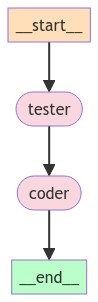

In [30]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Test

In [34]:
finalState = graph.invoke({"question": "Create a program that takes a pandas DataFrame prints summary statisticas and plots all numeric data in a boxplot."})

-----------generating tests-----------
tests="```\nimport unittest\nfrom io import StringIO\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\nclass TestProgram(unittest.TestCase):\n\n    def test_load_data(self):\n        df = pd.read_csv('test_data.csv')\n        self.assertEqual(df.shape, (5, 3))\n\n    def test_summary_statistics(self):\n        outcapture = StringIO()\n        with redirect_stdout(outcapture):\n            from your_program import print_stats\n            print_stats(pd.DataFrame([[1, 2], [3, 4]]))\n        self.assertIn('count', outcapture.getvalue())\n        self.assertIn('mean', outcapture.getvalue())\n\n    def test_plot_numeric_data(self):\n        df = pd.DataFrame([[1, 2, 'a'], [3, 4, 'b'], [5, 6, 'c']])\n        plt.savefig('test.png')\n        self.assertTrue(os.path.exists('test.png'))\n\nif __name__ == '__main__':\n    unittest.main()\n```"
-----------generating code-----------
code="Here is the Python code module that meets the requirements:\n``

In [35]:
print(finalState["code"])

Here is the Python code module that meets the requirements:
```
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

def print_stats(df):
    stats = df.describe()
    out = StringIO()
    print(stats.to_string(), file=out)
    return out.getvalue()

def plot_numeric_data(df):
    numeric_cols = [col for col in df.columns if df[col].dtype.kind in 'bifc']
    plt.boxplot([df[col].values for col in numeric_cols])
    plt.title('Box Plot of Numeric Data')
    plt.show()

def main():
    df = pd.read_csv('test_data.csv')  # replace with your file name
    print_stats(df)
    plot_numeric_data(df)

if __name__ == '__main__':
    main()
```


In [36]:
print(finalState["tests"])

```
import unittest
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

class TestProgram(unittest.TestCase):

    def test_load_data(self):
        df = pd.read_csv('test_data.csv')
        self.assertEqual(df.shape, (5, 3))

    def test_summary_statistics(self):
        outcapture = StringIO()
        with redirect_stdout(outcapture):
            from your_program import print_stats
            print_stats(pd.DataFrame([[1, 2], [3, 4]]))
        self.assertIn('count', outcapture.getvalue())
        self.assertIn('mean', outcapture.getvalue())

    def test_plot_numeric_data(self):
        df = pd.DataFrame([[1, 2, 'a'], [3, 4, 'b'], [5, 6, 'c']])
        plt.savefig('test.png')
        self.assertTrue(os.path.exists('test.png'))

if __name__ == '__main__':
    unittest.main()
```
